# ANÁLISIS PARTE II

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Cargar datos económicos
# Asegúrate de tener estos archivos en tu carpeta
df_costes = pd.read_csv('../data/processed/CO614_costes_estructura_clean.csv')
df_precios = pd.read_csv('../data/processed/CO497_indice_precios_clean.csv')

print("Datos Económicos Cargados:")
print(f"- Costes (Filas): {df_costes.shape[0]}")
print(f"- Precios (Filas): {df_precios.shape[0]}")

Datos Económicos Cargados:
- Costes (Filas): 2080
- Precios (Filas): 40


## Desglose de Costes
### ¿En qué se gasta el dinero un transportista?

In [5]:
# Queremos ver la evolución por tipo de vehículo
# Agrupamos por Año, Vehículo y Tipo de Coste (Directo/Indirecto).

df_costes_full = df_costes.groupby(['Año', 'Vehiculo', 'Tipo Costes'])['Costes Totales'].sum().reset_index()

# Calculamos el Coste Total Anual por vehículo (sumando directos e indirectos)
df_costes_totales = df_costes_full.groupby(['Año', 'Vehiculo'])['Costes Totales'].sum().reset_index()

# Indexamos a Base 100 (Año 2017 = 100)
# Esto nos permite ver PORCENTAJE de subida, sin importar si el camión cuesta 100k o 50k.
df_costes_totales['Indice_Base_100'] = df_costes_totales.groupby('Vehiculo')['Costes Totales'].transform(
    lambda x: (x / x.iloc[0]) * 100 if len(x) > 0 else 0
)

# El archivo de precios ya viene indexado, pero vamos a asegurarnos de tener el precio medio anual
df_precios_anual = df_precios.groupby('Año')['Precio Medio'].mean().reset_index()
# Re-indexamos a base 100 real sobre 2017
precio_2017 = df_precios_anual.loc[df_precios_anual['Año'] == 2017, 'Precio Medio'].values[0]
df_precios_anual['Indice_Precio_Mercado'] = (df_precios_anual['Precio Medio'] / precio_2017) * 100

# Guardamos dos archivos:
# 1. Detalle de costes por vehículo (para filtrar en el dashboard)
df_costes_totales.to_csv('KPI_Costes_Historico_Vehiculos.csv', index=False)

# 2. Referencia de precios de mercado (para comparar)
df_precios_anual.to_csv('KPI_Precios_Mercado_Historico.csv', index=False)

print("✅ Análisis Parte II corregido: Histórico completo generado.")
print("   - KPI_Costes_Historico_Vehiculos.csv (Incluye todos los tipos de camión)")
print("   - KPI_Precios_Mercado_Historico.csv (Referencia de mercado)")

✅ Análisis Parte II corregido: Histórico completo generado.
   - KPI_Costes_Historico_Vehiculos.csv (Incluye todos los tipos de camión)
   - KPI_Precios_Mercado_Historico.csv (Referencia de mercado)


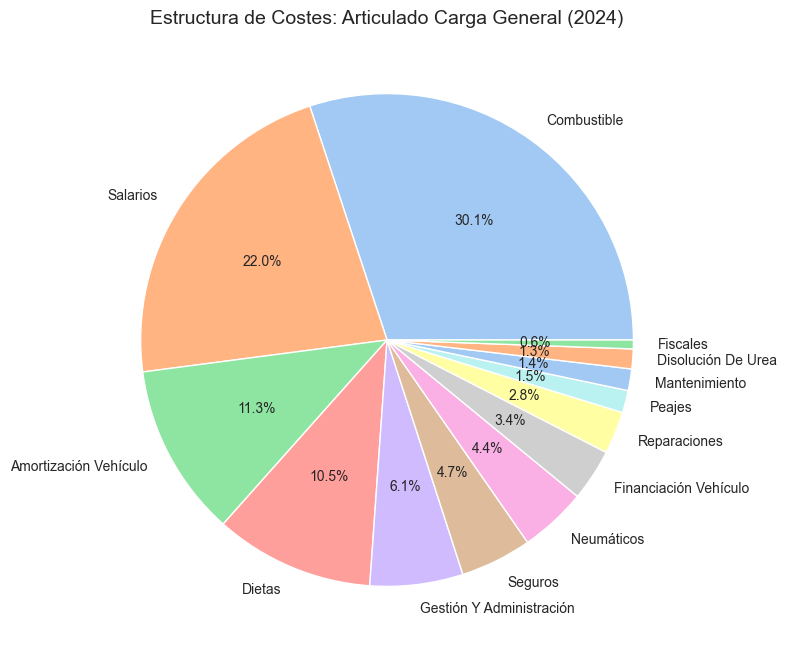

In [9]:
# Filtramos datos recientes y tipo de vehículo común
anio_max = df_costes['Año'].max()
filtro_vehiculo = "Articulado Carga General"

df_2024 = df_costes[
    (df_costes['Año'] == anio_max) & 
    (df_costes['Vehiculo'] == filtro_vehiculo) &
    (df_costes['Tipo Costes'] != 'Costes Totales') # Evitamos duplicar el total
]

# 2. Agrupamos por concepto de coste
# Usamos 'Subcategoría Costes' para ver detalle (Combustible, Personal, etc.)
desglose_costes = df_2024.groupby('Tipo Costes')['Costes Totales'].sum().sort_values(ascending=False)

# 3. Visualizamos
plt.figure(figsize=(10, 8))
colores = sns.color_palette('pastel')
plt.pie(desglose_costes, labels=desglose_costes.index, autopct='%1.1f%%', colors=colores)
plt.title(f'Estructura de Costes: {filtro_vehiculo} ({anio_max})', fontsize=14)
plt.show()

## Evolución Coste vs Precio
### ¿Se repercute la subida de costes a los clientes?

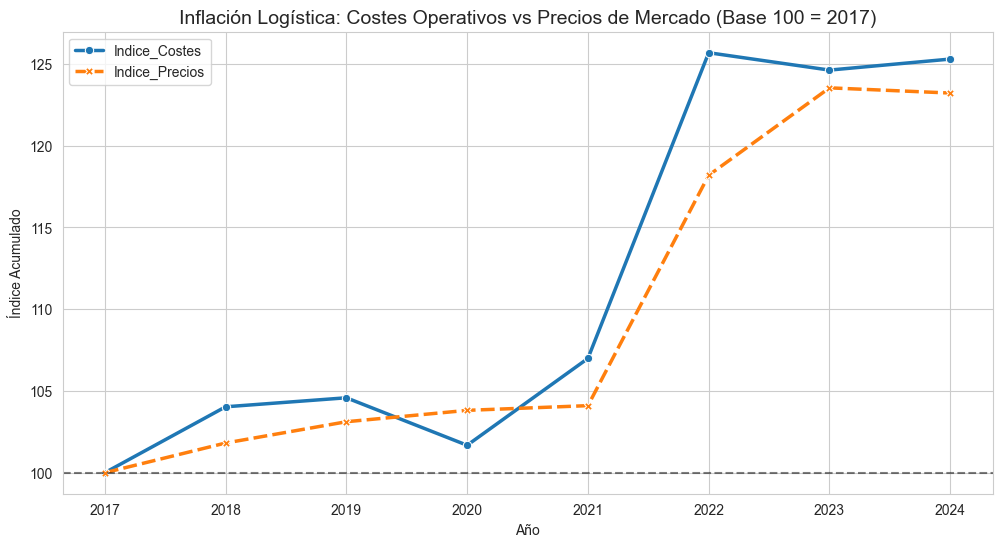

In [11]:
# 1. Preparar Costes: Suma total por año para el vehículo estándar
evolucion_costes = df_costes[df_costes['Vehiculo'] == filtro_vehiculo].groupby('Año')['Costes Totales'].sum()
# Normalizamos a base 100 para comparar (Año 2017 = 100)
base_coste = evolucion_costes.iloc[0]
indice_costes = (evolucion_costes / base_coste) * 100

# 2. Preparar Precios: Promedio del índice de precios por año
# El archivo CO497 ya trae un 'Índice Variación', pero vamos a reconstruir un índice base 100 aproximado
# Ojo: CO497 tiene precios medios en euros. Usaremos el precio medio total por año.
evolucion_precios = df_precios.groupby('Año')['Precio Medio'].mean()
base_precio = evolucion_precios.iloc[0]
indice_precios = (evolucion_precios / base_precio) * 100

# 3. Unir en un solo DataFrame para graficar
df_comparativo = pd.DataFrame({
    'Indice_Costes': indice_costes,
    'Indice_Precios': indice_precios
})

# 4. Gráfico de Líneas Comparativo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_comparativo, markers=True, linewidth=2.5)

plt.title('Inflación Logística: Costes Operativos vs Precios de Mercado (Base 100 = 2017)', fontsize=14)
plt.ylabel('Índice Acumulado')
plt.axhline(100, color='black', linestyle='--', alpha=0.5) # Línea base
plt.show()

In [ ]:
df_comparativo.reset_index().to_csv('../data/processed/KPI_Costes_vs_Precios.csv', index=False)
print("✅ KPI Económico guardado.")

✅ KPI Económico guardado.
